In [22]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

In [30]:
start_date='2014-1-1'
end_date='2017-12-31'

Study of https://github.com/yinanzhu12/Quantopian-notes/blob/master/research%20notes/Pair%20trading%20using%20clustering%20algorithm.ipynb suggest that some stocks have some what close relation, among them is such a pair (RY: Cannadian Royal Bank; BMO: Bank of Montreal):

In [31]:
bmo_price=get_pricing('BMO',start_date=start_date,end_date=end_date,fields='close_price')
ry_price=get_pricing('RY',start_date=start_date,end_date=end_date,fields='close_price')

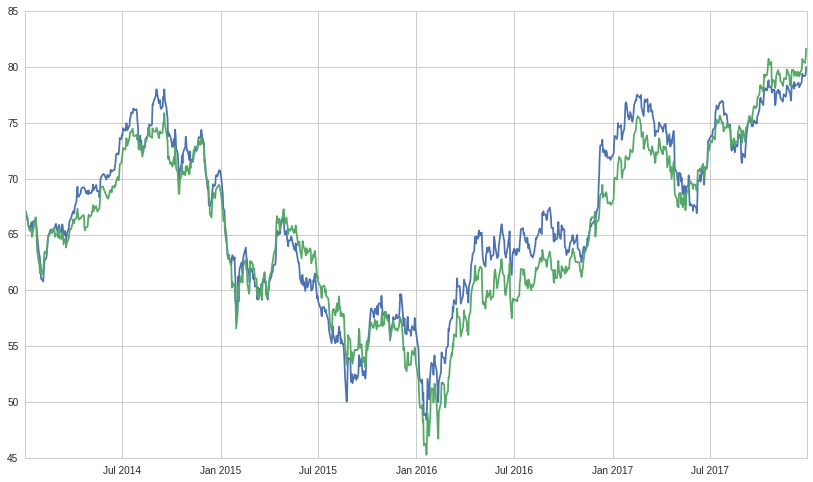

In [6]:
plt.figure()
plt.plot(bmo_price)
plt.plot(ry_price)
plt.show()

augmented dickey fuller test, (with the null hypothesis that there is a unit root), suggest neither price series are stationary

In [5]:
adfuller(bmo_price)

(-0.99706763896481021,
 0.75433230936868023,
 1,
 1005,
 {'1%': -3.4368734638130847,
  '10%': -2.5683035273879358,
  '5%': -2.8644201518188126},
 1954.4904126074325)

In [6]:
adfuller(ry_price)

(-0.57135017812116751,
 0.87732519871982251,
 0,
 1006,
 {'1%': -3.436866962597422,
  '10%': -2.5683020002450507,
  '5%': -2.8644172846037028},
 1964.3714823306539)

Running a Engle-Granger two-step cointegration test, there is certain possibility that they are cointegrated

In [173]:
coint(bmo_price,ry_price)

(-3.1297396374065878,
 0.08248442414629803,
 array([-3.43686047, -2.86441442, -2.56830048]))

In [14]:
x=np.array(bmo_price)
x=sm.add_constant(x)
y=np.array(ry_price)

In [15]:
model=sm.OLS(y,x)

In [16]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 1.459e+04
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        01:35:09   Log-Likelihood:                -2079.9
No. Observations:                1007   AIC:                             4164.
Df Residuals:                    1005   BIC:                             4174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0516      0.547     -0.094      0.925        -1.126     1.023
x1             0.9849      0.008    120.787      0.000         0.969     1.001
==============================================================================
Omnibus:                      197.199   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.225
Skew:                           0.174   Prob(JB):                     1.51e-10
Kurtosis:                       2.022   Cond. No.                         610.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

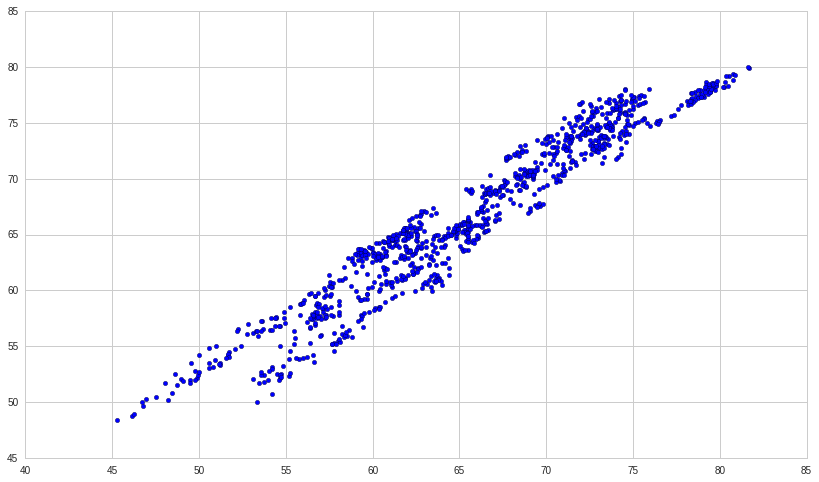

In [33]:
plt.figure()
plt.scatter(ry_price,bmo_price)
plt.show()

we create a spread using result of linear regression

In [5]:
spread=ry_price-0.9849*bmo_price

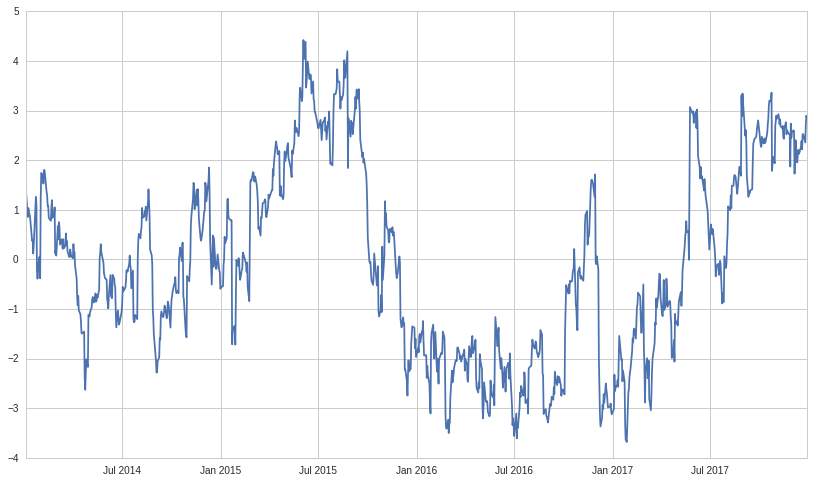

In [6]:
plt.figure()
plt.plot(spread)
plt.show()

Actually we do not need another Dickey-fuller test here because it was already doen in Engle-Granger two-step cointegration test above

In [9]:
adfuller(spread)

(-3.021784123982008,
 0.032909512342576788,
 0,
 1006,
 {'1%': -3.436866962597422,
  '10%': -2.5683020002450507,
  '5%': -2.8644172846037028},
 833.30218787441731)

A ar(1) model would help us estimate the half life

In [20]:
ar_model=ARIMA(spread,(1,0,0))
ar_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1007
Model:                     ARMA(1, 0)   Log Likelihood                -439.266
Method:                       css-mle   S.D. of innovations              0.374
Date:                Fri, 23 Mar 2018   AIC                            884.532
Time:                        01:57:02   BIC                            899.276
Sample:                    01-02-2014   HQIC                           890.134
                         - 12-29-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1709      0.601      0.285      0.776        -1.006     1.348
ar.L1.y        0.9812      0.006    163.151      0.000         0.969     0.993
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0191           +0.0000j            1.0191            0.0000
-----------------------------------------------------------------------------
"""

In [11]:
hl=np.log(0.5)/np.log(0.9812)
hl

36.521861029050399

compute z_score using rolling mean

In [235]:
w=60
roll_mean=spread.rolling(window=w).mean()
roll_std=spread.rolling(window=w).std()
zscore=(spread-roll_mean)/roll_std

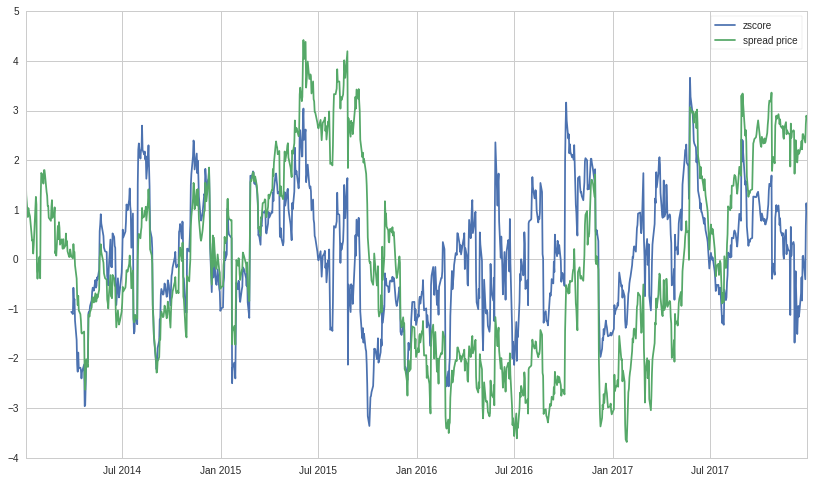

In [189]:
plt.figure()
plt.plot(zscore_60)
plt.plot(spread)
plt.legend(['zscore','spread price'])
plt.show()

A simple strategy: buy one share when z_score smaller than entry_z, short one when z_score greater than entry_z. Clear the portfolio when zscore surpasses the plus/minus exit_z line

In [12]:
def mean_reverse_1(spread,look_back=60,entry_z=1,exit_z=0):
    share=0
    cash=0
    roll_mean=spread.rolling(window=look_back).mean()
    roll_std=spread.rolling(window=look_back).std()
    zscore=(spread-roll_mean)/roll_std
    capital=[0]
    for index in spread.index:
        if not np.isnan(zscore[index]):
            if share==0:
                capital.append(capital[-1])
                if zscore[index]>entry_z:
                    share=-1
                    print('sell at price '+str(spread[index]))
                    cash=cash-share*spread[index]
                elif zscore[index]<-entry_z:
                    share=1
                    print('buy at price '+str(spread[index]))
                    cash=cash-share*spread[index]
            elif share>0:
                capital.append(cash+share*spread[index])
                if zscore[index]>-exit_z:
                    print('sell at price '+str(spread[index]))
                    share=0
                    cash=capital[-1]
                if zscore[index]>entry_z:
                    print('sell at price '+str(spread[index]))
                    share=-1
                    cash=cash-share*spread[index]
            else:
                capital.append(cash+share*spread[index])
                if zscore[index]<exit_z:
                    print('buy at price '+str(spread[index]))
                    share=0
                    cash=capital[-1]
                if zscore[index]<-entry_z:
                    print('buy at price '+str(spread[index]))
                    share=1
                    cash=cash-share*spread[index]
    return capital

In [17]:
cap=mean_reverse_1(spread,look_back=60)

buy at price 0.063244
sell at price 0.042085
sell at price -0.217651
buy at price -1.198021
buy at price -1.198021
sell at price 0.023708
sell at price 0.023708
buy at price -0.992132
buy at price -1.182736
sell at price -0.460116
buy at price -1.536073
sell at price -0.334646
sell at price 0.687234
buy at price -0.5070675
buy at price -0.591977
sell at price 0.454116
sell at price 1.204588
buy at price -1.71021
buy at price -1.71021
sell at price 0.277174
sell at price 1.556351
buy at price 2.640749
buy at price 1.924996
sell at price 2.976959
sell at price 3.833184
buy at price 3.039979
sell at price 4.014158
buy at price 1.842716
buy at price 1.842716
sell at price 3.022297
buy at price 2.413622
sell at price -1.454298
buy at price -3.162452
sell at price -2.031063
sell at price -1.645797
buy at price -2.3694441
buy at price -2.684238
sell at price -1.910463
buy at price -2.951167
sell at price -1.8503705
sell at price -1.163751
buy at price -2.3130055
buy at price -2.953011
sell at

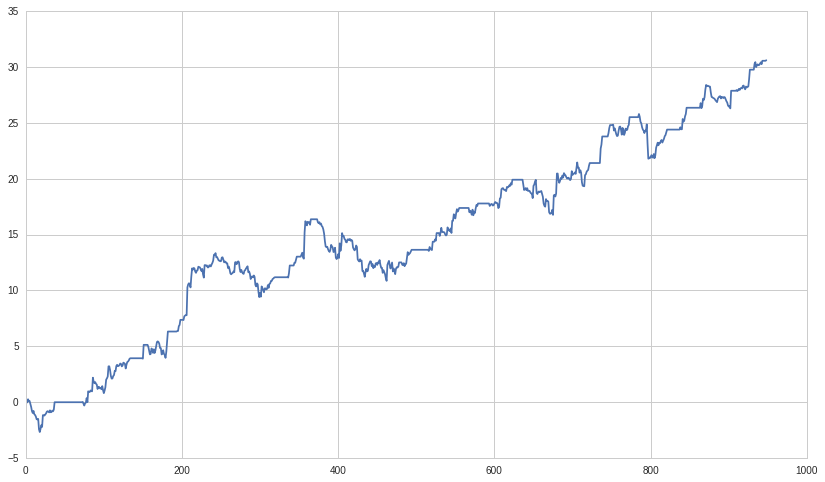

In [18]:
plt.figure()
plt.plot(cap)
plt.show()

This result doesn't mean much as it is a result of look ahead bias, now we use only first 500 days result to build trading strategy

In [251]:
x=np.array(bmo_price)[:500]
x=sm.add_constant(x)
y=np.array(ry_price)[:500]

In [252]:
model=sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.010e+04
Date:                Fri, 16 Mar 2018   Prob (F-statistic):               0.00
Time:                        01:23:48   Log-Likelihood:                -844.08
No. Observations:                 500   AIC:                             1692.
Df Residuals:                     498   BIC:                             1701.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          8.3301      0.563     14.808      0.000         7.225     9.435
x1             0.8661      0.009    100.492      0.000         0.849     0.883
==============================================================================
Omnibus:                       12.262   Durbin-Watson:                   0.077
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.562
Skew:                          -0.354   Prob(JB):                      0.00187
Kurtosis:                       3.320   Cond. No.                         626.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [259]:
spread=ry_price-0.8661*bmo_price

In [254]:
adfuller(spread[:500])

(-2.8005477198455533,
 0.058195572770927406,
 0,
 499,
 {'1%': -3.4435228622952065,
  '10%': -2.569864247011056,
  '5%': -2.8673495105661462},
 375.11423364586346)

In [260]:
cap_2=mean_reverse_1(spread)

buy at price 7.683149
sell at price 7.572049
sell at price 8.31571
buy at price 7.532458
sell at price 8.222532
buy at price 7.792553
sell at price 8.943212
buy at price 8.117452
buy at price 7.622266
sell at price 8.483499
buy at price 7.259259
sell at price 8.316613
sell at price 9.162426
buy at price 8.370928
buy at price 7.5802425
sell at price 8.793532
buy at price 5.76231
sell at price 8.923139
sell at price 9.066189
buy at price 7.780153
sell at price 8.732342
buy at price 9.908559
buy at price 9.268081
sell at price 10.089027
buy at price 8.158124
sell at price 9.680462
buy at price 8.736158
sell at price 4.963278
buy at price 3.190972
sell at price 4.590589
sell at price 4.962693
buy at price 4.631837
sell at price 5.8175755
buy at price 5.152246
sell at price 5.86367
buy at price 5.120174
buy at price 4.340121
sell at price 5.2259601
sell at price 5.655073
buy at price 4.853351
sell at price 6.1505405
buy at price 6.241948
buy at price 5.433478
sell at price 7.322957
buy at p

This strategy is still profitable even after 500 days, but the profit shrinks

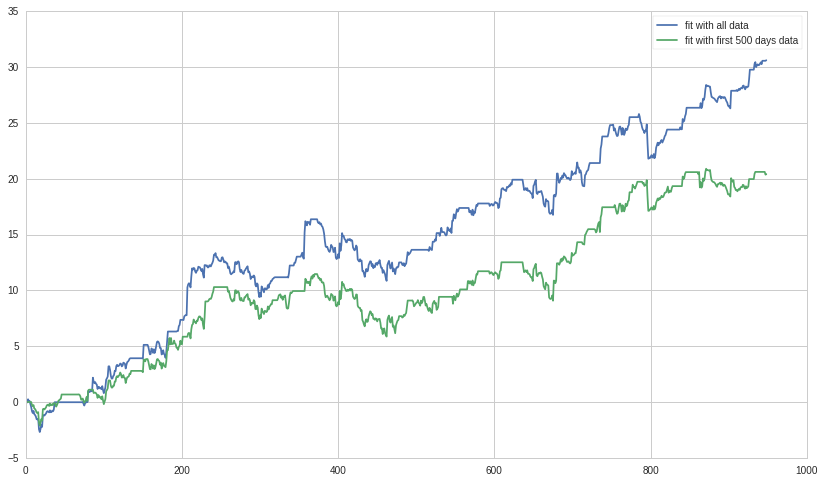

In [263]:
plt.figure()
plt.plot(cap)
plt.plot(cap_2)
plt.legend(['fit with all data','fit with first 500 days data'])
plt.show()

A more apropriate strategy is instead of buying 1 share every time, keep investing a certain proportion of capital in the portfolio (leverage). We implement the strategy in quantopian environment and test the result (all with leverage 1)

The algorithm with look ahead bias:

100% Time: 0:00:01|###########################################################|


Start date,2014-01-06
End date,2017-12-29
Total months,47
,Backtest
Annual return,3.9%
Cumulative returns,16.4%
Annual volatility,3.6%
Sharpe ratio,1.08
Calmar ratio,1.13
Stability,0.92
Max drawdown,-3.4%


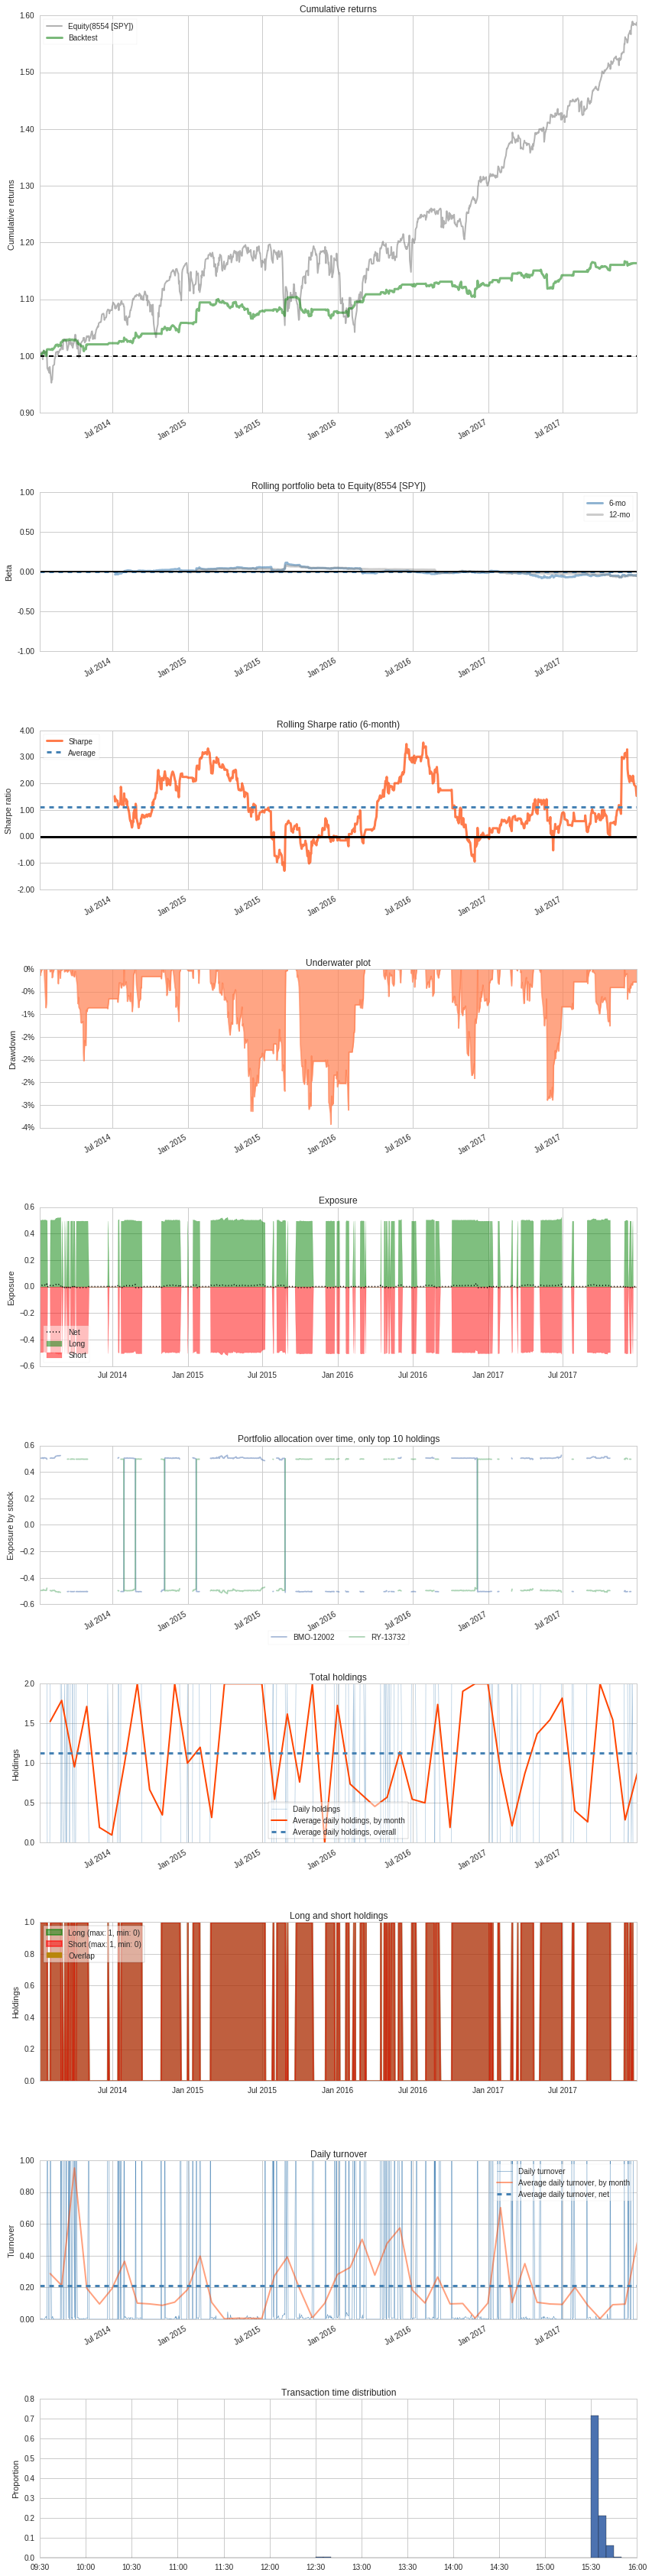

In [4]:
bt = get_backtest('5ab300da0ddace414b0dd155')
bt.create_simple_tear_sheet()

The one with 'half-look-ahead' bias (using the first half of data to determine beta)

100% Time: 0:00:01|###########################################################|


Start date,2014-01-06
End date,2017-12-29
Total months,47
,Backtest
Annual return,2.7%
Cumulative returns,11.2%
Annual volatility,3.8%
Sharpe ratio,0.72
Calmar ratio,0.71
Stability,0.86
Max drawdown,-3.8%


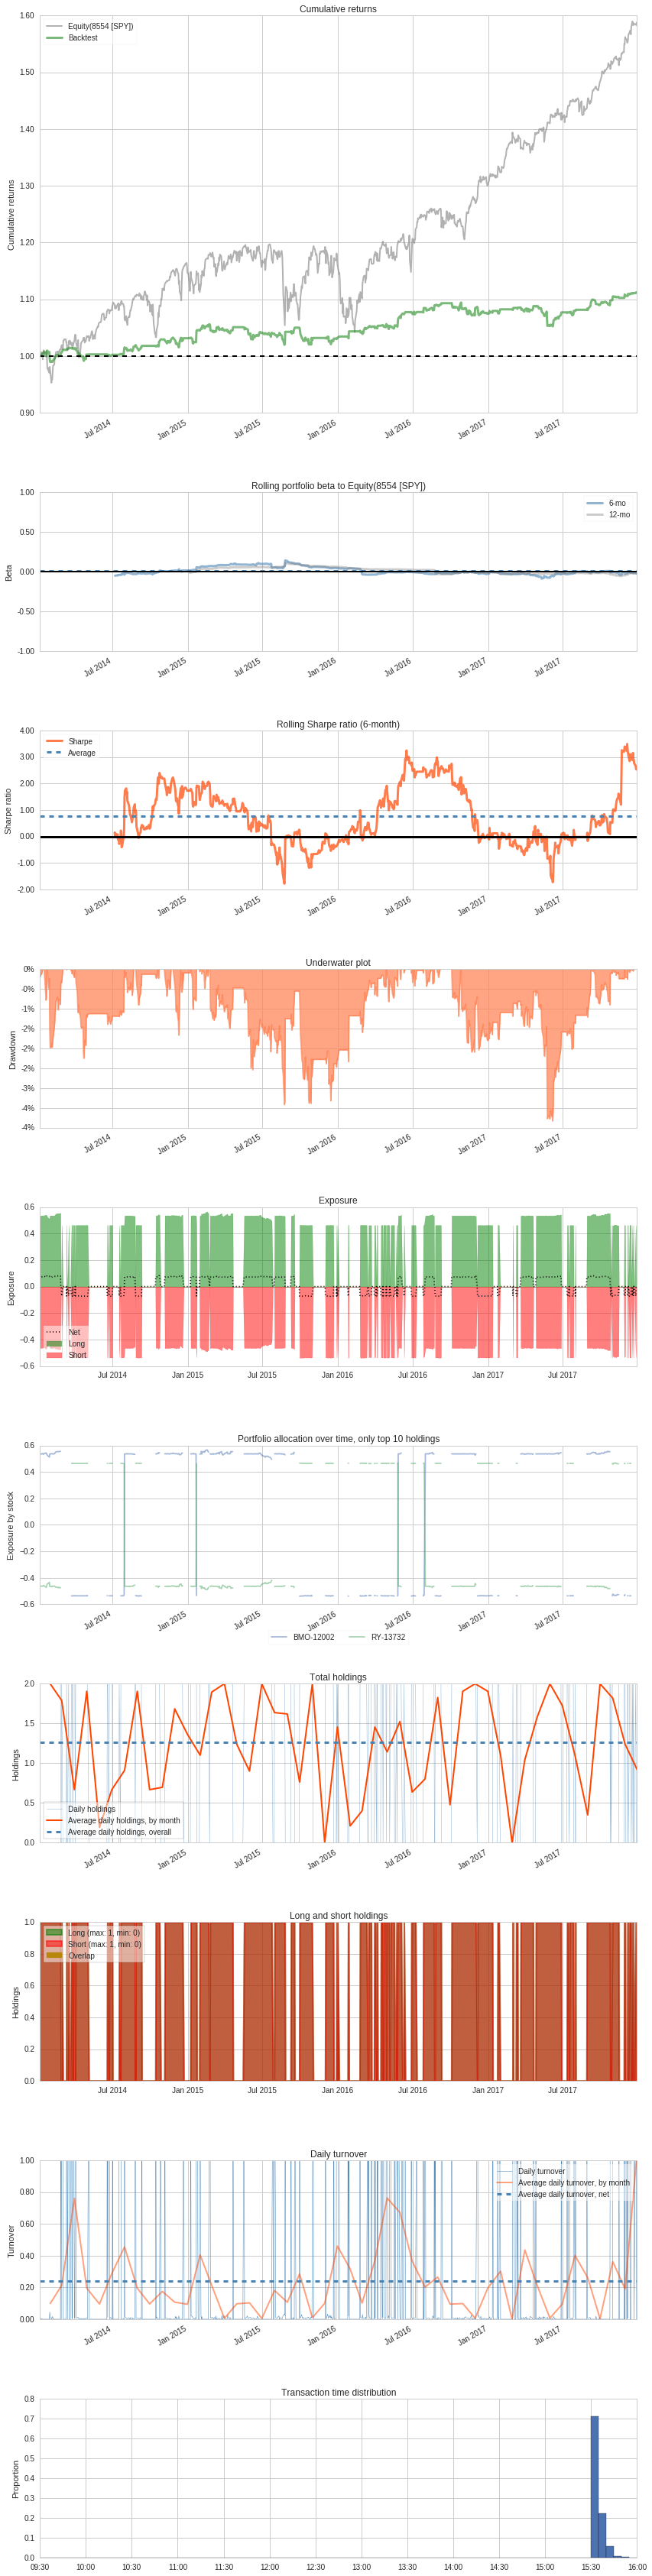

In [38]:
bt=get_backtest('5ab302531f002840cf20c4fd')
bt.create_simple_tear_sheet()

In order to achieve a strategy without any look ahead bias, I propose to adjust the spread online using moving regression result which involves only the most recent n-days' data (n is adjustable), and to rebalance the portfolio constantly to meet the new spread. This is inspired by https://www.quantopian.com/lectures/example-pairs-trading-algorithm. I cannot find any theoretical reason why this would work. But it seems to give sharpe>0.5 for most of the test and a very low beta. After some parameter tunning (we have two look-back parameters, one is how many data used to compute z-score, the other is how many data used to estimate the hedge ratio), the best backtest is:

100% Time: 0:00:01|###########################################################|


Start date,2014-01-06
End date,2017-12-29
Total months,47
,Backtest
Annual return,5.7%
Cumulative returns,24.7%
Annual volatility,4.8%
Sharpe ratio,1.17
Calmar ratio,1.20
Stability,0.95
Max drawdown,-4.7%


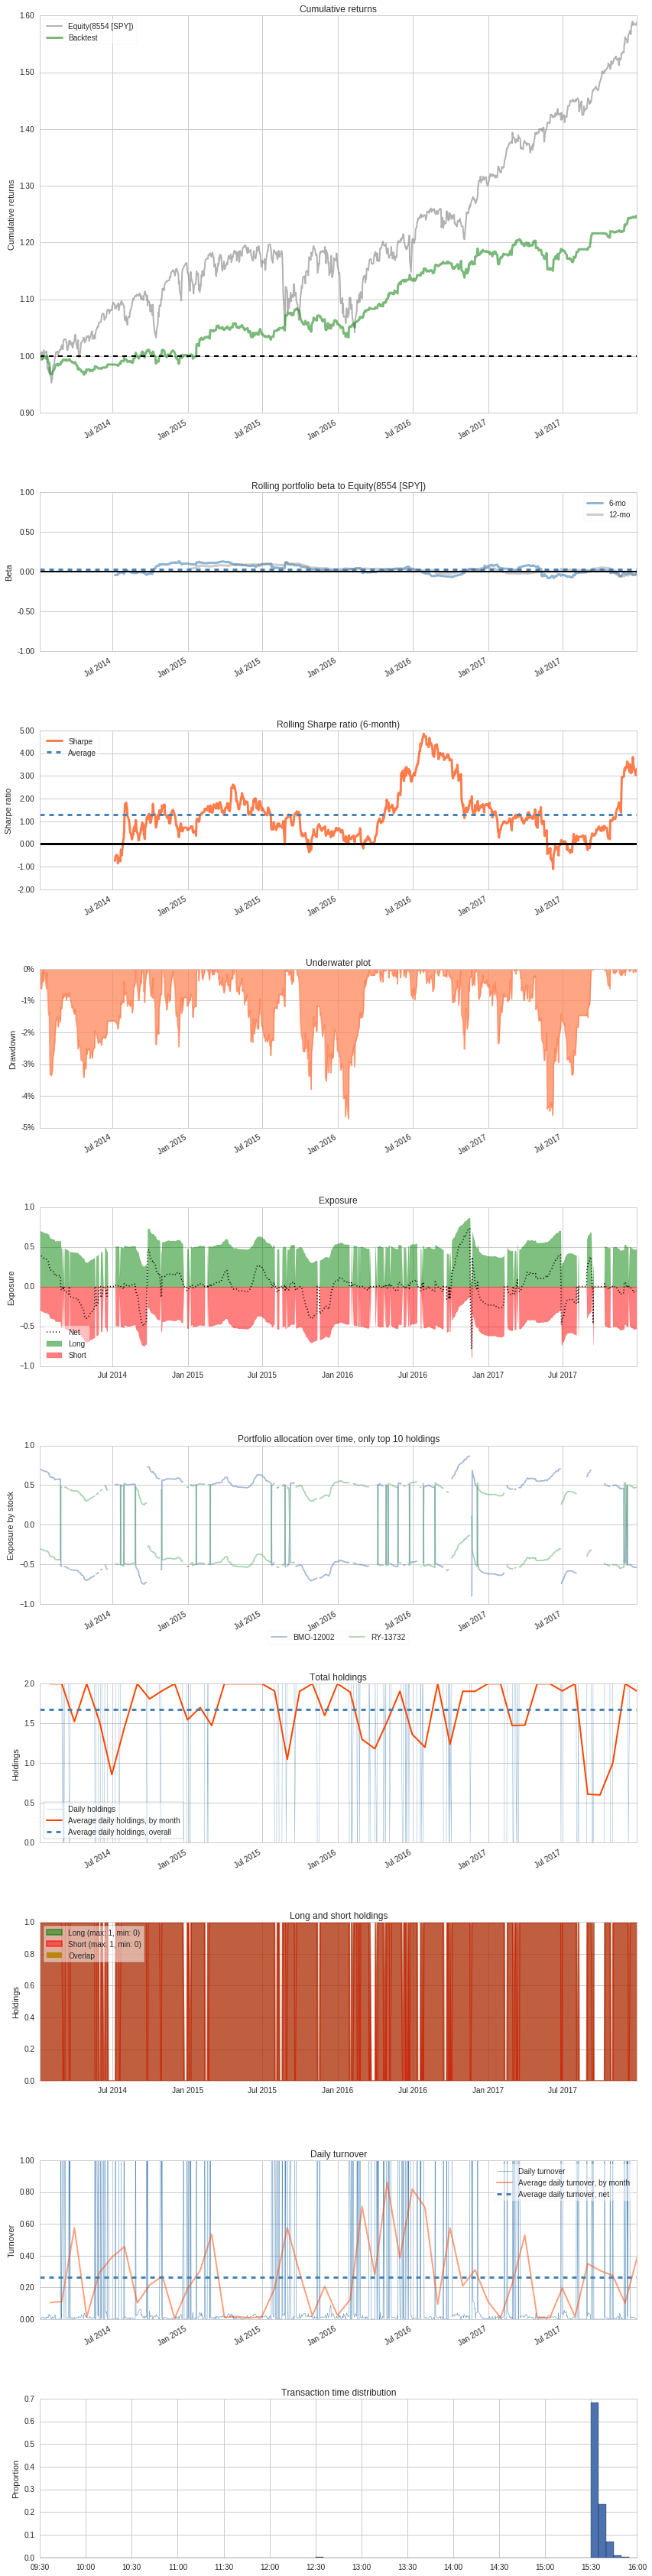

In [35]:
bt=get_backtest('5ab45d7aa2133741145329f0')
bt.create_simple_tear_sheet()

This strategy works somehow in a longer time spans (2010-2017), though there is a very long non-profitable period

100% Time: 0:00:02|###########################################################|


Start date,2010-01-06
End date,2017-12-29
Total months,95
,Backtest
Annual return,4.6%
Cumulative returns,43.6%
Annual volatility,6.4%
Sharpe ratio,0.74
Calmar ratio,0.57
Stability,0.71
Max drawdown,-8.2%


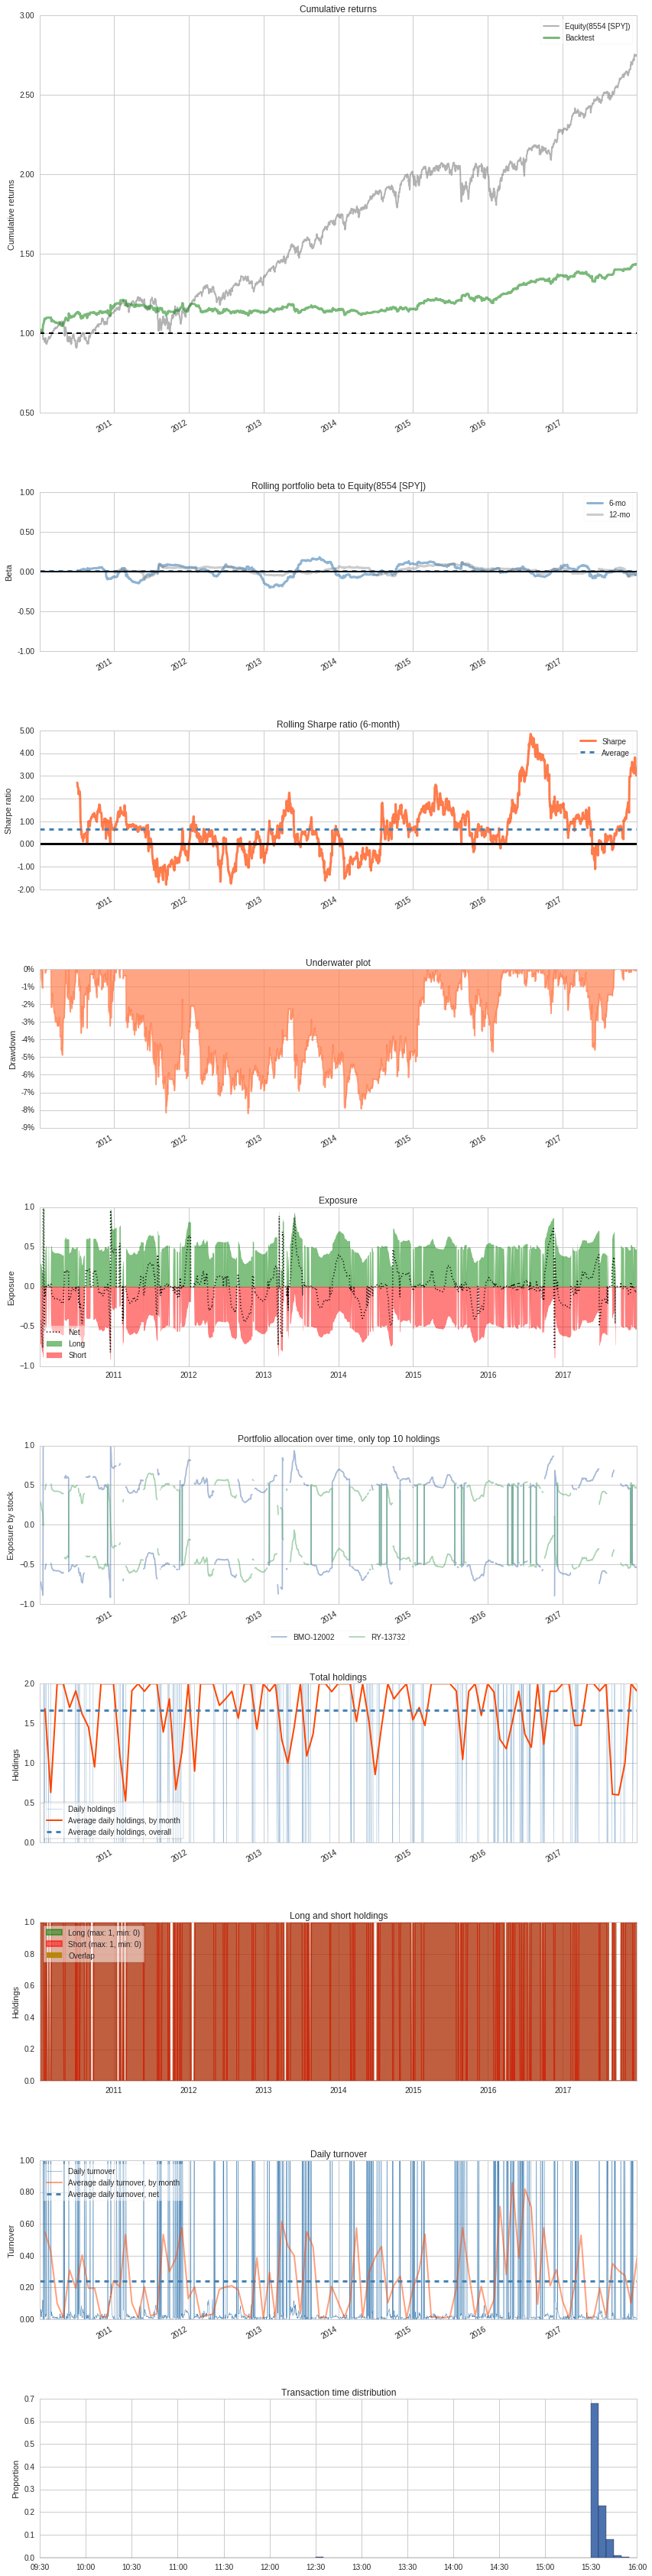

In [36]:
bt=get_backtest('5ab6ab403dbdb542a3e1da00')
bt.create_simple_tear_sheet()